In [1]:
# !pip install arch

In [2]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()

# import statsmodels.graphics.tsaplots as sgt # ACF and PACF
# import statsmodels.tsa.stattools as sts  # for dickey fuller test
# from arch import arch_model
# import scipy.stats as scs
# import numpy as np

# from scipy.stats.distributions import chi2 # for LLR test

# import scipy.stats
# import pylab # for qq plot
# from statsmodels.stats.diagnostic import het_arch

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.graphics.tsaplots as sgt # ACF and PACF
import statsmodels.tsa.stattools as sts  # for dickey fuller test
# from arch import arch_model
# import scipy.stats as scs
import numpy as np

from scipy.stats.distributions import chi2 # for LLR test

import scipy.stats
import pylab # for qq plot
from statsmodels.stats.diagnostic import het_arch

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Load raw data

In [5]:
data=pd.read_csv('/content/KOSPI 200 Historical Data (26 Dec 2000 to 7 march 2025).csv')

# Remove unused columns

In [6]:
data=data.drop(['Unnamed: 0','Open','High','Low','Vol.','Change %'],axis=1)

In [7]:
data["Date"]=pd.to_datetime(data["Date"],dayfirst=True)
data.set_index("Date",inplace=True)
data=data.asfreq('b')
data_copy=data.copy()

In [8]:
data.head()

,Price
Date,
2000-12-26,63.35
2000-12-27,NaN
2000-12-28,NaN
2000-12-29,NaN
2001-01-01,NaN


# Taking data from 1st Jan 2001

In [9]:
data=data.iloc[4:]

In [10]:
data.head()

,Price
Date,
2001-01-01,NaN
2001-01-02,65.41
2001-01-03,65.38
2001-01-04,70.14
2001-01-05,73.15


# Imputing missing values

In [11]:
data.isna().sum()

,0
Price,340


## Using interpolation to fill missing values

In [12]:
data['Price']=data['Price'].interpolate(method='spline', order=3)

In [13]:
data.isna().sum()

,0
Price,1


In [14]:
data.head()

,Price
Date,
2001-01-01,NaN
2001-01-02,65.41
2001-01-03,65.38
2001-01-04,70.14
2001-01-05,73.15


## Using back-fill to fill first value

In [15]:
data['Price']=data['Price'].bfill()

In [16]:
data.isna().sum()

,0
Price,0


In [17]:
data.head()

,Price
Date,
2001-01-01,65.41
2001-01-02,65.41
2001-01-03,65.38
2001-01-04,70.14
2001-01-05,73.15


In [18]:
data.shape

(6310, 1)

In [19]:
data.shape

(6310, 1)

# Price graph

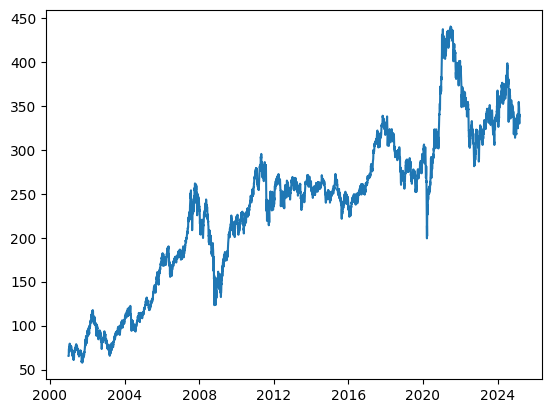

In [20]:
plt.plot(data['Price'])
plt.show()

# Log Return

In [24]:
data['log_return'] = np.log(data['Price']).diff()

In [25]:
data.isna().sum()

,0
Price,0
log_return,1


## Using back-fill to fill missing value of log returns

In [26]:
data['log_return'] = data['log_return'].bfill()

In [27]:
data.isna().sum()

,0
Price,0
log_return,0


In [28]:
data.head()

,Price,log_return
Date,,
2001-01-01,65.41,0.000000
2001-01-02,65.41,0.000000
2001-01-03,65.38,-0.000459
2001-01-04,70.14,0.070277
2001-01-05,73.15,0.042019


## Scalling Log Return

In [29]:
standard_scaler_for_log_return=StandardScaler()

In [30]:
data['scaled_log_return']=standard_scaler_for_log_return.fit_transform(data['log_return'].values.reshape(-1,1))

In [31]:
data['scaled_log_return'].describe()

,scaled_log_return
count,6.310000e+03
mean,1.238664e-17
std,1.000079e+00
min,-9.498217e+00
25%,-4.674228e-01
50%,2.294909e-02
75%,5.046483e-01
max,8.567113e+00


### Scaled log returns plots

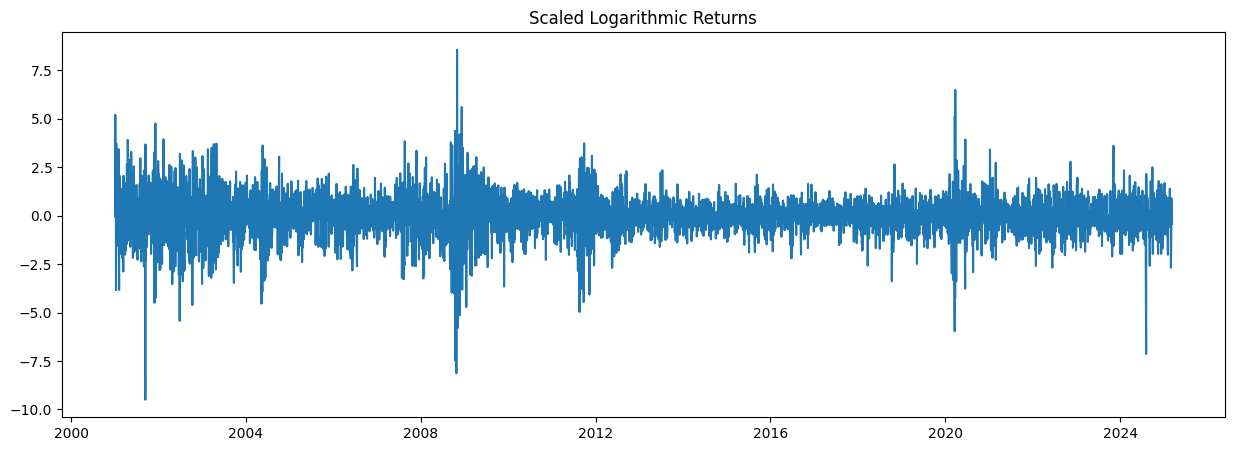

In [32]:
plt.figure(figsize=(15,5))
plt.plot(data.index,data['scaled_log_return'])
plt.title('Scaled Logarithmic Returns')
plt.show()

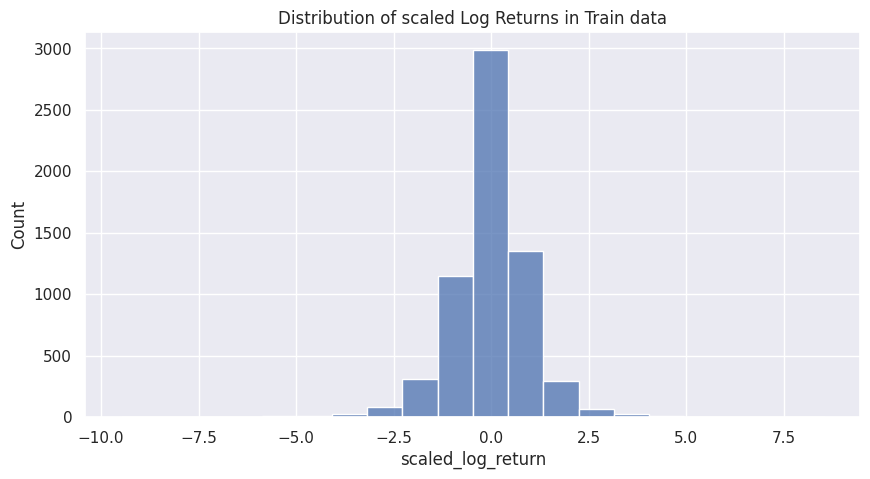

In [37]:
plt.figure(figsize=(10,5))
sns.histplot(data['scaled_log_return'], bins=20)
plt.title('Distribution of scaled Log Returns in Train data')
plt.show()


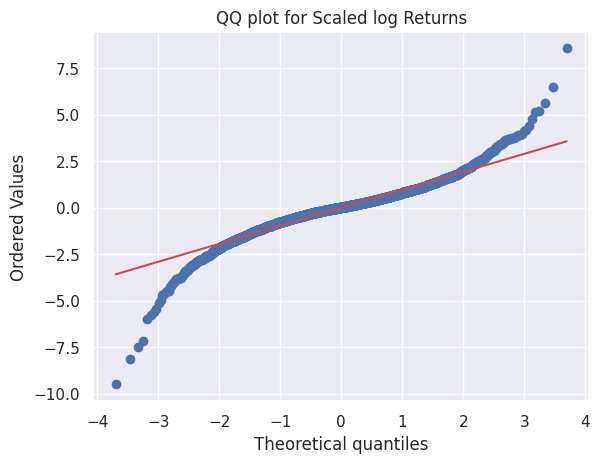

In [42]:
scipy.stats.probplot(data['scaled_log_return'],plot=pylab)
plt.title('QQ plot for Scaled log Returns')
pylab.show()

# Realised Volatilty

In [43]:
def add_realised_volatility(data_frame,window_size=5):
  array=np.zeros([data_frame.shape[0]])
  array[:]=np.nan
  for i in range(len(data_frame)-window_size+1):
    array[i]=data_frame['log_return'].iloc[i:i+window_size].std()

  data_frame[f'realised_volatility_of_{window_size}']=array
  data_frame[f'realised_volatility_of_{window_size}']=data_frame[f'realised_volatility_of_{window_size}'].ffill()
  return data_frame

In [44]:
data=add_realised_volatility(data,5)

In [45]:
data.isna().sum()

,0
Price,0
log_return,0
scaled_log_return,0
realised_volatility_of_5,0


## Scaling Realised volatility of 5

In [46]:
min_max_scaler_for_realised_vol=MinMaxScaler()
data['scaled_realised_volatility_of_5']=min_max_scaler_for_realised_vol.fit_transform(data['realised_volatility_of_5'].values.reshape(-1,1))

### Scaled Reaslised Volatility plots

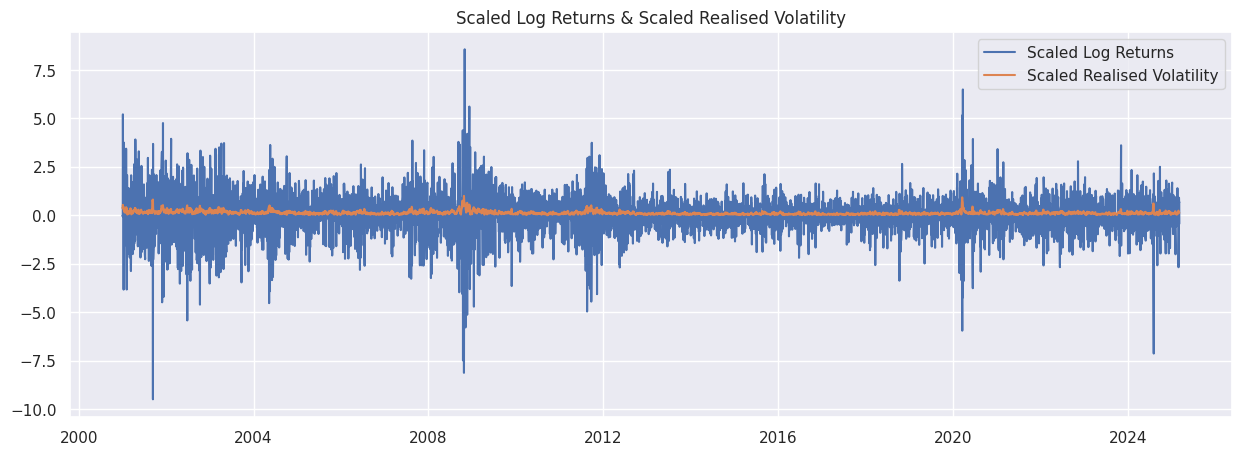

In [47]:
plt.figure(figsize=(15,5))
plt.plot(data['scaled_log_return'])
plt.plot(data['scaled_realised_volatility_of_5'])
plt.legend(['Scaled Log Returns','Scaled Realised Volatility'])
plt.title('Scaled Log Returns & Scaled Realised Volatility')
plt.show()

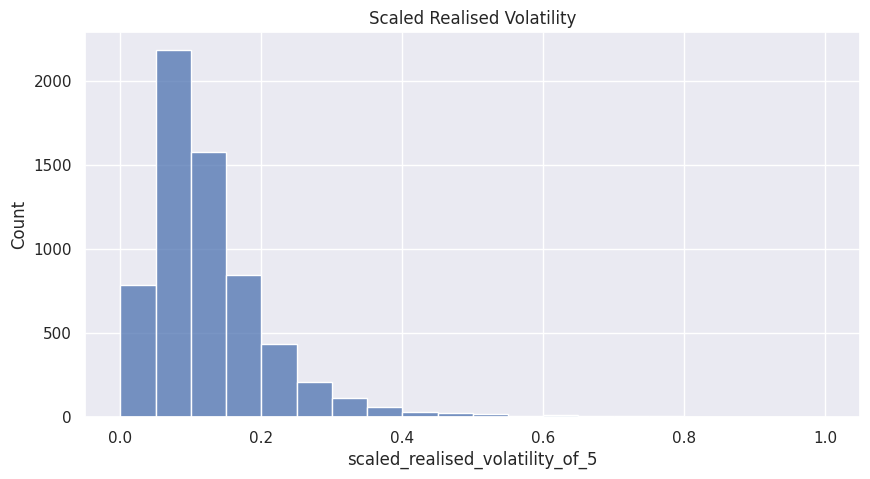

In [48]:
plt.figure(figsize=(10,5))
sns.histplot(data['scaled_realised_volatility_of_5'], bins=20)
plt.title('Scaled Realised Volatility')
plt.show()

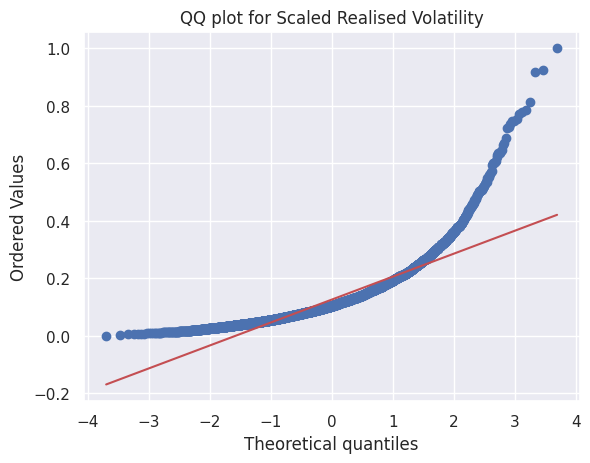

In [49]:
scipy.stats.probplot(data['scaled_realised_volatility_of_5'].astype(np.float64),plot=pylab)
plt.title('QQ plot for Scaled Realised Volatility')
pylab.show()

# ADF Test

- Ho: data is non-stationary (t-statistics>critical value)
- H1: data is stationary (t-statistics<critical value)

In [50]:
def adf_test(series):
  test_statistic, pvalue, usedlag, nobs, critical_values, icbest=sts.adfuller(series)

  result={'Test_Statistic':test_statistic,'P_value':pvalue,'Used_Lag':usedlag,'Used_Obs':nobs,'Critical_values':critical_values,'Info_Criterion':icbest}
  print(f'Name:{series.name}')
  for key,value in result.items():
    print(f'{key}:{value}')

  print('\n__Interpretation__')
  if result['P_value']<0.05: print(f'\nP_value < 0.05\nReject Ho: {series.name} is stationary')
  else: print(f'\nP_value > 0.05\nFail to reject Ho: {series.name} is not stationary')
  return result

In [51]:
scaled_log_return_adf_results=adf_test(data['scaled_log_return'])

Name:scaled_log_return
Test_Statistic:-41.263920117320346
P_value:0.0
Used_Lag:3
Used_Obs:6306
Critical_values:{'1%': np.float64(-3.431387418951288), '5%': np.float64(-2.8619984478958043), '10%': np.float64(-2.5670140287739898)}
Info_Criterion:17719.468398660065

__Interpretation__

P_value < 0.05
Reject Ho: scaled_log_return is stationary


**Interpretation:** Logarithmic return is stationary

In [52]:
scaled_realised_volatility_of_5_adf_results=adf_test(data['scaled_realised_volatility_of_5'])

Name:scaled_realised_volatility_of_5
Test_Statistic:-6.830340664141878
P_value:1.900805008501985e-09
Used_Lag:30
Used_Obs:6279
Critical_values:{'1%': np.float64(-3.4313918817280418), '5%': np.float64(-2.8620004197048536), '10%': np.float64(-2.5670150784144337)}
Info_Criterion:-23319.58688931055

__Interpretation__

P_value < 0.05
Reject Ho: scaled_realised_volatility_of_5 is stationary


**Interpretation:** Realised Volatility is stationary

# Jarque bera Test

In [53]:
from scipy.stats import jarque_bera

In [54]:
stat,p = jarque_bera(data['scaled_realised_volatility_of_5'])
print(f"Jarque-Bera Test Statistic: {stat}")
print(f"P-value: {p}")

if p > 0.05:
    print("Data looks normal (fail to reject H0)")
else:
    print("Data does not look normal (reject H0)")


Jarque-Bera Test Statistic: 41654.08301959867
P-value: 0.0
Data does not look normal (reject H0)


In [55]:
from scipy.stats import jarque_bera


stat,p = jarque_bera(data['scaled_log_return'])
print(f"Jarque-Bera Test Statistic: {stat}")
print(f"P-value: {p}")

if p > 0.05:
    print("Data looks normal (fail to reject H0)")
else:
    print("Data does not look normal (reject H0)")


Jarque-Bera Test Statistic: 12287.408979425521
P-value: 0.0
Data does not look normal (reject H0)


# ARCH LM Test

In [56]:
lm_stat, lm_pval, f_stat, f_pval=het_arch(data['scaled_log_return'])
print(f"LM Statistic: {lm_stat}")
print(f"LM Test p-value: {lm_pval}")
print(f"F-Statistic: {f_stat}")
print(f"F-Test p-value: {f_pval}")

# Interpretation
if lm_pval < 0.05:
    print("Reject null hypothesis: ARCH effects are present.")
else:
    print("Fail to reject null hypothesis: No significant ARCH effects.")


LM Statistic: 935.9047029735993
LM Test p-value: 1.1890263196514117e-194
F-Statistic: 109.72781710764593
F-Test p-value: 4.758277171845509e-211
Reject null hypothesis: ARCH effects are present.


In [57]:
lm_stat, lm_pval, f_stat, f_pval=het_arch(data['scaled_realised_volatility_of_5'])
print(f"LM Statistic: {lm_stat}")
print(f"LM Test p-value: {lm_pval}")
print(f"F-Statistic: {f_stat}")
print(f"F-Test p-value: {f_pval}")

# Interpretation
if lm_pval < 0.05:
    print("Reject null hypothesis: ARCH effects are present.")
else:
    print("Fail to reject null hypothesis: No significant ARCH effects.")

LM Statistic: 4954.922301254347
LM Test p-value: 0.0
F-Statistic: 2316.7067881393114
F-Test p-value: 0.0
Reject null hypothesis: ARCH effects are present.


**Interpretation:** Heteroskedasticity is present

# PACF for log returns and squared log returns

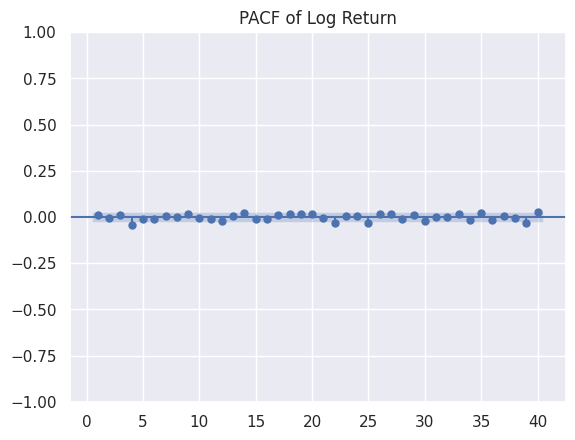

In [58]:
sgt.plot_pacf(data['scaled_log_return'][1:],lags=40,zero=False)
plt.title('PACF of Log Return')
plt.show()

In [59]:
data['squared_log_return']=data['scaled_log_return']**2

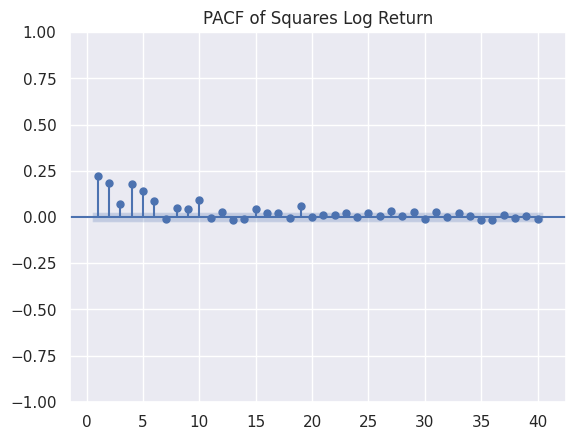

In [60]:
sgt.plot_pacf(data['squared_log_return'][1:],lags=40,zero=False)
plt.title('PACF of Squares Log Return')
plt.show()

In [61]:
data

,Price,log_return,scaled_log_return,realised_volatility_of_5,scaled_realised_volatility_of_5,squared_log_return
Date,,,,,,
2001-01-01,65.410000,0.000000,-0.019382,0.032416,0.379606,0.000376
2001-01-02,65.410000,0.000000,-0.019382,0.031055,0.363380,0.000376
2001-01-03,65.380000,-0.000459,-0.053517,0.030148,0.352559,0.002864
2001-01-04,70.140000,0.070277,5.209798,0.045589,0.536702,27.141995
2001-01-05,73.150000,0.042019,3.107171,0.033568,0.393350,9.654515
...,...,...,...,...,...,...
2025-03-03,329.893498,-0.013179,-1.000022,0.011213,0.126748,1.000044
2025-03-04,334.020000,0.012431,0.905588,0.011213,0.126748,0.820089
2025-03-05,337.080000,0.009119,0.659179,0.011213,0.126748,0.434517


# Saving clean and pocessed data

In [62]:
data.to_feather('/content/clean_data_cols_price_lr_slr_sslr_rv_srv.feather')